# Module 3: Machine Learning

## Sprint 2: Intermediate Machine Learning

## House prices regression competition, part 2

## Background

---

Participating in Kaggle competitions is an efficient way to learn some aspects of Machine Learning. You can read solutions made public by the others, participate in the discussions to talk about solution ideas and test them by submitting them for evaluation.

The metric used for evaluation can vary from competition to competition, but the idea remains the same - build a model that is as accurate as possible on the testing set. In industry, there are other factors to consider when building machine learning models - inference time, solution complexity, maintainability and so on. However, even though you only learn a subset of the required skills while participating in Kaggle competitions, it is quite a fun way to learn by doing it, so let's participate in one of the tutorial competitions again!

## The competition

In this notebook we will again participate in the Kaggle competition below:

- https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

For help, you can look at some of the notebooks by other competitors. However, try to write code by yourself, as even though you will always be able to consult external resources while working as a professional, the main thing right now is to learn by first trying it yourself.

---

## Concepts to explore

- Neural network regressor in scikit-learn https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
- Gradient boosting regressor in scikit-learn https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
- xgboost for regression https://www.geeksforgeeks.org/xgboost-for-regression/

## Requirements

- Build and submit a scikit-learn pipeline having neural network regressor as the model
- Build and submit a scikit-learn pipeline having gradient boosted regressor as the model
- Build and submit a xgboost model
- Achieve a score better than 0.13 on the public leaderboard

## Evaluation criteria

- Public leaderboard score
- How simple is the model
- How fast is the model prediction
- Code quality


## Sample correction questions

During a correction, you may get asked questions that test your understanding of covered topics.

- How can model regularization help and what are some of the ways to use regularization?
- What are the benefits and the risks of hyper-parameter optimization?
- Why is it useful to crossvalidate your model using many splits? Why sometimes a single validation split is still used?
- Why is it useful to build a pipeline that encapsulates all the preprocessing, model training and other steps?

# Data set

## Information given by authors
*   23 nominal, 23 ordinal, 14 discrete, and 20 continuous
*   I will say that the 80 variables focus on the quality and quantity of many physical attributes of the property
*   In general the 20 continuous variables relate to various area dimensions for each observation.
*   Area measurements on the basement, main living area, and even porches are broken down into individual categories based on quality and type
*   The 14 discrete variables typically quantify the number of items occurring within the house.
*   The nominal variables typically identify various types of dwellings, garages, materials, and environmental conditions while the ordinal variables typically rate various items within the property.
*    all sales that had occurred within Ames from 2006 to 2010

## Notes

1. Check how important is are **Condition1** and **Condition2**. Each column has 9 nominal values. Second column might have nulls because it defines a second condition if it applies. It would not make sense to encode condition2 with most frequent values if it has any NaN. But also if the features are not usefull it would be nice to drop them, since they would introduce 16+2 columns when encoded.
2. **OverallQual** and **OverallCond** columns are ordinal and already encoded with int values. Highest values mean better quality and condition and lower values mean poorer quality and condition. I could try leaving them the way they are and therefore introducing some bias. It could make the model perform better. 
3. **Exterior1** and **Exterior2** same logic as #1 applies.
4. **MiscVal**: $Value of miscellaneous feature. This columns is related with MiscFeature. So if I drop one I should drop another.
5. **MoSold** is encoded in integer values, however it should not be.
6. Make all continuous variables float.
7. Discrete into int.
8. Discrete into strings.
9. Remove houses with general living area above 4000 k sq.feet
10. Get rid of ID column it's useless.

# Data Import

In [1]:
import missingno as msno
import numpy as np
import pandas as pd
import sys

In [66]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [67]:
df = train.copy()
df.shape

(1460, 81)

# Missing Data

## Continues Variables

In [68]:
df_continuos = df[['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtUnfSF','BsmtFinSF1', 'BsmtFinSF2', 'EnclosedPorch', 'GarageArea','GrLivArea', 'LotArea',
                   'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF']]
df_continuos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       1460 non-null   int64  
 1   2ndFlrSF       1460 non-null   int64  
 2   3SsnPorch      1460 non-null   int64  
 3   BsmtUnfSF      1460 non-null   int64  
 4   BsmtFinSF1     1460 non-null   int64  
 5   BsmtFinSF2     1460 non-null   int64  
 6   EnclosedPorch  1460 non-null   int64  
 7   GarageArea     1460 non-null   int64  
 8   GrLivArea      1460 non-null   int64  
 9   LotArea        1460 non-null   int64  
 10  LotFrontage    1201 non-null   float64
 11  LowQualFinSF   1460 non-null   int64  
 12  MasVnrArea     1452 non-null   float64
 13  MiscVal        1460 non-null   int64  
 14  OpenPorchSF    1460 non-null   int64  
 15  PoolArea       1460 non-null   int64  
 16  ScreenPorch    1460 non-null   int64  
 17  TotalBsmtSF    1460 non-null   int64  
 18  WoodDeck

In [69]:
# Looking at NaN % within the train

nan = pd.DataFrame(df_continuos.isna().sum(), columns = ['NaN_sum'])
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan

,NaN_sum,Perc(%)
MasVnrArea,8,0.547945
LotFrontage,259,17.739726


In [70]:
df_continuos.drop(columns=['MiscVal', 'PoolArea', 'LotFrontage','MasVnrArea'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
# continues values should be floats
df_continuos = df_continuos.astype(float)

In [72]:
# linearly dependent features
df_continuos[['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']].head()

,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea
0,856.0,854.0,0.0,1710.0
1,1262.0,0.0,0.0,1262.0
2,920.0,866.0,0.0,1786.0
3,961.0,756.0,0.0,1717.0
4,1145.0,1053.0,0.0,2198.0


In [73]:
df_continuos.drop(columns=['1stFlrSF', 'LowQualFinSF'], inplace=True)

1st floor sq.feet, 2nd floor sq.feet, low quality finished sq.feet add up to general living area aproximately.

In [74]:
df_continuos[['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF']].head()

,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF
0,150.0,706.0,0.0,856.0
1,284.0,978.0,0.0,1262.0
2,434.0,486.0,0.0,920.0
3,540.0,216.0,0.0,756.0
4,490.0,655.0,0.0,1145.0


In [75]:
df_continuos.drop(columns=['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2'], inplace=True)

Different quality types of basement add up to total basement sq.feet.

In [107]:
# possible feature to use
df_continuos['TotalPorchSF'] = df_continuos['3SsnPorch'] + df_continuos['EnclosedPorch'] + df_continuos['OpenPorchSF'] + df_continuos['ScreenPorch'] + df_continuos['WoodDeckSF']
df_continuos.drop(columns=['3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'OpenPorchSF', 'WoodDeckSF'], inplace=True)

1. **LotFrontage** is expressesed by the column **LotArea** so I dropped it.
2. **MasVnrArea** dropping since it doesn't seem like an informative feature.
3. By looking at the values for **MiscFeature** I decided that it wasn't a very informative feature and therefore I'm dropping it. As well as **MiscVal** since its value depends on the former.
4. Data set description says that in **PoolQC** and **Alley** na values mean absesnse of a feaure on a property. So I will drop the columns as well. Even if having those features has significant effect on the price of the house, there are not enough values to train the model with crossvalidation.**PoolArea** is related to **PoolQC** so it will be discarded as well.


In [108]:
df_continuos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   2ndFlrSF      1460 non-null   float64
 1   GarageArea    1460 non-null   float64
 2   GrLivArea     1460 non-null   float64
 3   LotArea       1460 non-null   float64
 4   TotalBsmtSF   1460 non-null   float64
 5   TotalPorchSF  1460 non-null   float64
dtypes: float64(6)
memory usage: 68.6 KB


## Discrete Variables

In [109]:
df_discrete = df[['BedroomAbvGr','BsmtFullBath','BsmtHalfBath', 'Fireplaces', 'FullBath', 'GarageCars', 'GarageYrBlt',
                  'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd','YearBuilt','YearRemodAdd', 'YrSold']]
df_discrete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BedroomAbvGr  1456 non-null   int64  
 1   BsmtFullBath  1456 non-null   int64  
 2   BsmtHalfBath  1456 non-null   int64  
 3   Fireplaces    1456 non-null   int64  
 4   FullBath      1456 non-null   int64  
 5   GarageCars    1456 non-null   int64  
 6   GarageYrBlt   1375 non-null   float64
 7   HalfBath      1456 non-null   int64  
 8   KitchenAbvGr  1456 non-null   int64  
 9   TotRmsAbvGrd  1456 non-null   int64  
 10  YearBuilt     1456 non-null   int64  
 11  YearRemodAdd  1456 non-null   int64  
 12  YrSold        1456 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 159.2 KB


In [110]:
# Looking at NaN % within the train

nan = pd.DataFrame(df_discrete.isna().sum(), columns = ['NaN_sum'])
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan

,NaN_sum,Perc(%)
GarageYrBlt,81,5.547945


In [111]:
df_discrete.drop(columns=['GarageYrBlt'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 **GarageYrBlt** is expressed by the column **YearBuilt** so I dropped it.

In [112]:
# discrete values should be int
df_discrete = df_discrete.astype(int)

In [113]:
df_discrete["TotalBath"] = (df_discrete["FullBath"] + 0.5 * df_discrete["HalfBath"] + df_discrete["BsmtFullBath"] + 0.5 * df_discrete["BsmtHalfBath"])

In [114]:
df_discrete.drop(columns=['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], inplace=True)

In [115]:
df_discrete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BedroomAbvGr  1456 non-null   int64  
 1   Fireplaces    1456 non-null   int64  
 2   GarageCars    1456 non-null   int64  
 3   KitchenAbvGr  1456 non-null   int64  
 4   TotRmsAbvGrd  1456 non-null   int64  
 5   YearBuilt     1456 non-null   int64  
 6   YearRemodAdd  1456 non-null   int64  
 7   YrSold        1456 non-null   int64  
 8   TotalBath     1456 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 113.8 KB


## Nominal Variables

In [116]:
df_nominal = df[['Alley','BldgType', 'CentralAir', 'Condition1', 'Condition2', 'Exterior1st','Exterior2nd', 'MoSold','Foundation','GarageType','Heating',
                 'HouseStyle', 'LandContour', 'LotConfig', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street']]
df_nominal.info()
'MiscFeature'
'Alley'
'MasVnrType'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Alley          91 non-null     object
 1   BldgType       1456 non-null   object
 2   CentralAir     1456 non-null   object
 3   Condition1     1456 non-null   object
 4   Condition2     1456 non-null   object
 5   Exterior1st    1456 non-null   object
 6   Exterior2nd    1456 non-null   object
 7   MoSold         1456 non-null   int64 
 8   Foundation     1456 non-null   object
 9   GarageType     1375 non-null   object
 10  Heating        1456 non-null   object
 11  HouseStyle     1456 non-null   object
 12  LandContour    1456 non-null   object
 13  LotConfig      1456 non-null   object
 14  MSSubClass     1456 non-null   int64 
 15  MSZoning       1456 non-null   object
 16  MasVnrType     1448 non-null   object
 17  MiscFeature    54 non-null     object
 18  Neighborhood   1456 non-null

'MasVnrType'

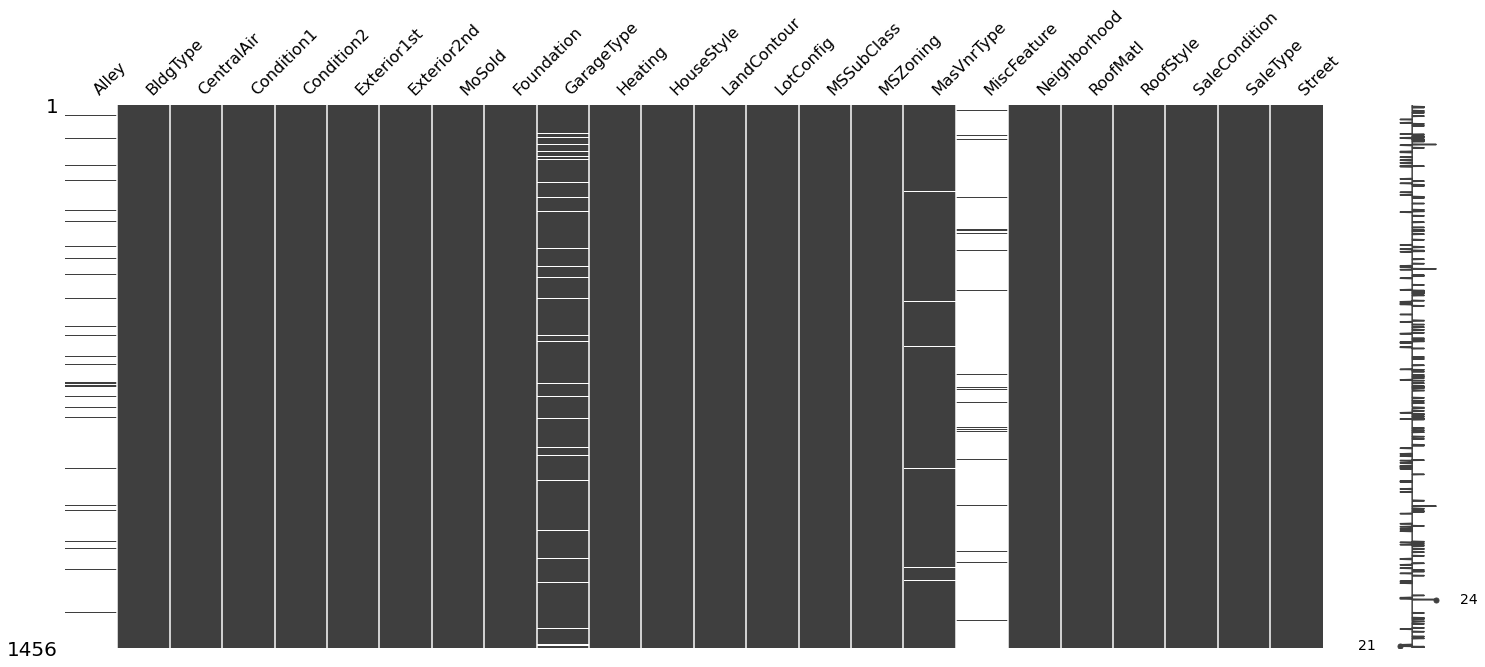

In [117]:
msno.matrix(df_nominal)

## Ordinal Variables

In [118]:
df_ordinal = df[['BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'ExterCond', 
                 'ExterQual', 'Fence', 'FireplaceQu', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
                 'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolQC', 'Utilities']]
df_ordinal.info()
'PoolQC'
'Fence'
'FireplaceQu'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtCond      1419 non-null   object
 1   BsmtExposure  1418 non-null   object
 2   BsmtQual      1419 non-null   object
 3   BsmtFinType1  1419 non-null   object
 4   BsmtFinType2  1418 non-null   object
 5   Electrical    1455 non-null   object
 6   ExterCond     1456 non-null   object
 7   ExterQual     1456 non-null   object
 8   Fence         280 non-null    object
 9   FireplaceQu   766 non-null    object
 10  Functional    1456 non-null   object
 11  GarageCond    1375 non-null   object
 12  GarageFinish  1375 non-null   object
 13  GarageQual    1375 non-null   object
 14  HeatingQC     1456 non-null   object
 15  KitchenQual   1456 non-null   object
 16  LandSlope     1456 non-null   object
 17  LotShape      1456 non-null   object
 18  OverallCond   1456 non-null   int64 
 19  Overal

'FireplaceQu'

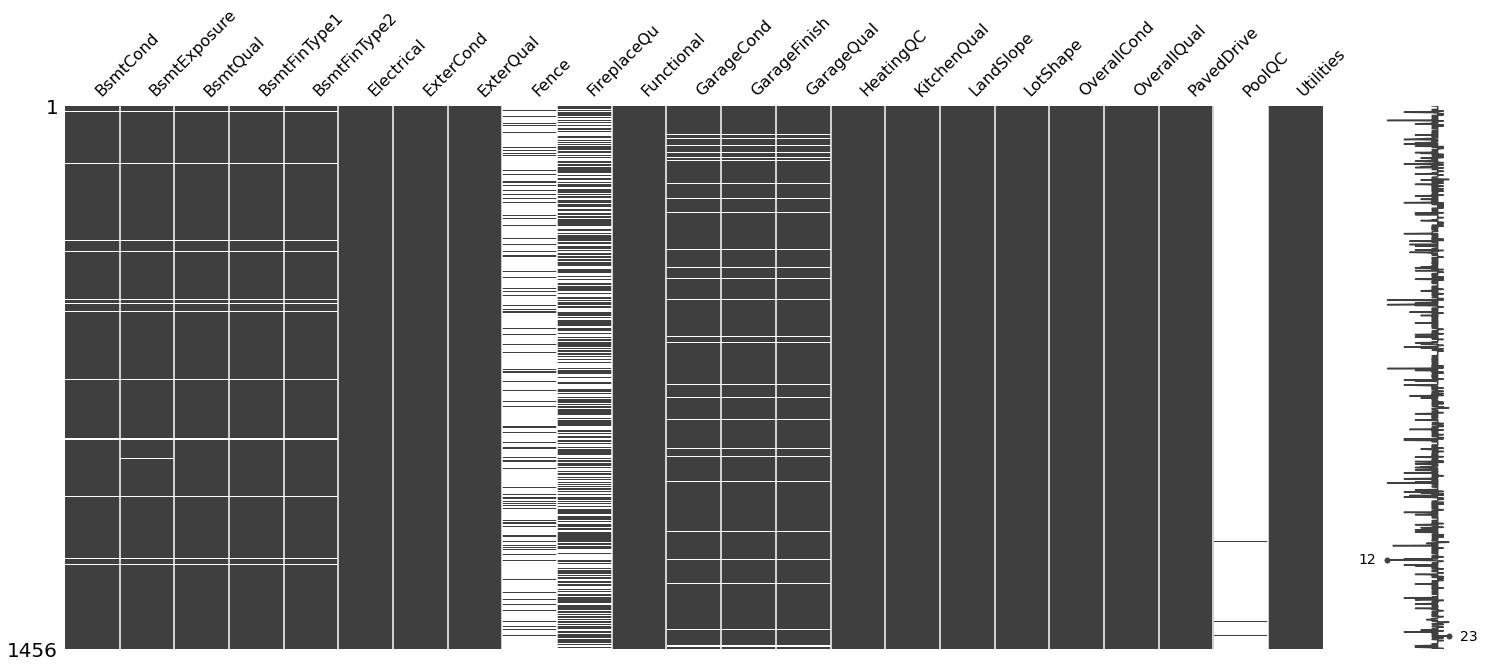

In [119]:
msno.matrix(df_ordinal)

# Baseline Models

In [120]:
numeric = pd.concat([df_discrete, df_continuos], axis=1)

In [121]:
# Filtering out houses above 4000 

index_names = numeric[numeric['GrLivArea'] >= 4000 ].index
numeric.drop(index_names, inplace = True)

In [122]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

gbr_cross = cross_validate(gbr, numeric, np.log1p(df['SalePrice']), cv=2, scoring=('neg_root_mean_squared_error'), return_train_score=True)
print("test_score:", np.mean(gbr_cross["test_score"]),"train_score:", np.mean(gbr_cross["train_score"]))

test_score: -0.15124762954218768 train_score: -0.09064515992292153


In [123]:
from xgboost import XGBRegressor

xgregressor = XGBRegressor()

xgregressor_cross = cross_validate(xgregressor, numeric, np.log1p(df['SalePrice']), scoring=('neg_root_mean_squared_error'), cv=2, return_train_score=True)
print("test_score:", np.mean(xgregressor_cross["test_score"]),"train_score:", np.mean(xgregressor_cross["train_score"]))

[18:44:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
test_score: -0.15069233590523373 train_score: -0.09974870545528064


In [142]:
test_numeric = test.copy()
test_numeric["TotalBath"] = (test_numeric["FullBath"] + 0.5 * test_numeric["HalfBath"] + test_numeric["BsmtFullBath"] + 0.5 * test_numeric["BsmtHalfBath"])
test_numeric['TotalPorchSF'] = test_numeric['3SsnPorch'] + test_numeric['EnclosedPorch'] + test_numeric['OpenPorchSF'] + test_numeric['ScreenPorch'] + test_numeric['WoodDeckSF']

In [143]:
 for column in test_numeric.columns.tolist():
  if column not in numeric.columns.tolist():
    test_numeric.drop(columns=[column], inplace=True)

In [144]:
# Looking at NaN % within the data

nan = pd.DataFrame(test_numeric.isna().sum(), columns = ['NaN_sum'])
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan

,NaN_sum,Perc(%)
TotalBsmtSF,1,0.068493
GarageCars,1,0.068493
GarageArea,1,0.068493
TotalBath,2,0.136986


In [145]:
# Imputing continuous variable
from sklearn.impute import SimpleImputer
imputer= SimpleImputer(missing_values=np.NaN, strategy="median")

In [146]:
test_numeric.TotalBsmtSF = imputer.fit_transform(test_numeric['TotalBsmtSF'].values.reshape(-1,1))[:,0]
test_numeric.GarageCars = imputer.fit_transform(test_numeric['GarageCars'].values.reshape(-1,1))[:,0]
test_numeric.GarageArea = imputer.fit_transform(test_numeric['GarageArea'].values.reshape(-1,1))[:,0]
test_numeric.TotalBath = imputer.fit_transform(test_numeric['TotalBath'].values.reshape(-1,1))[:,0]

In [147]:
for column in test_numeric.columns.tolist():
  if column in df_continuos.columns.tolist():
    test_numeric[column] = test_numeric[column].astype(float)
  elif column in df_discrete.columns.tolist():
    test_numeric[column] = test_numeric[column].astype(int)

In [151]:
numeric = numeric.reindex(sorted(numeric.columns), axis=1)
test_numeric = test_numeric.reindex(sorted(test_numeric.columns), axis=1)

In [154]:
gbr.fit(numeric, np.log1p(df['SalePrice']))
prediction = gbr.predict(test_numeric)
prediction = np.expm1(prediction)
prediction = pd.DataFrame(prediction, columns = ['SalePrice'])
prediction = pd.concat([test[['Id']], prediction], axis = 1, ignore_index=True )
prediction.to_csv('prediction.csv')
from google.colab import files
files.download("prediction.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>